# Absorbed Power Density Map of a Lossy Cylinder

The `dft_flux` routines (`add_flux`) described in the previous examples compute the *total* power in a given region (`FluxRegion`). It is also possible to compute the *local* (i.e., position-dependent) absorbed power density in a dispersive (lossy) material. This quantity is useful for obtaining a spatial map of the photon absorption. The absorbed power density is defined as $$\mathrm{Re}\, \left[ {\mathbf{E}^* \cdot \frac{d\mathbf{P}}{dt}} \right]$$ where $\mathbf{P}$ is the total polarization field. In the Fourier (frequency) domain with time-harmonic fields, this expression is $$\mathrm{Re}\, \left[ {\mathbf{E}^* \cdot (-i \omega \mathbf{P})} \right] = \omega\, \mathrm{Im}\, \left[ {\mathbf{E}^* \cdot \mathbf{P}} \right]$$ where $\mathbf{E}^* \cdot \mathbf{P}$ denotes the dot product of the complex conjugate of $\mathbf{E}$ with $\mathbf{P}$. However, since $\mathbf{D}=\mathbf{E}+\mathbf{P}$, this is equivalent to $$ \omega\, \mathrm{Im}\, \left[ {\mathbf{E}^* \cdot (\mathbf{D}-\mathbf{E})} \right] = \omega\, \mathrm{Im}\, \left[ {\mathbf{E}^* \cdot \mathbf{D}} \right]$$ since $\mathbf{E}^* \cdot \mathbf{E} = |\mathbf{E}|^2$ is purely real. Calculating this quantity involves two steps: (1) compute the Fourier-transformed $\mathbf{E}$ and $\mathbf{D}$ fields in a region via the `dft_fields` feature and (2) in post processing, compute $\omega\, \mathrm{Im}\, \left[ {\mathbf{E}^* \cdot \mathbf{D}} \right]$.

This tutorial example involves computing the absorbed power density for a two-dimensional cylinder (radius: 1 μm) of silicon dioxide (SiO<sub>2</sub>, from the [materials library](https://meep.readthedocs.io/en/latest/Materials/#materials-library)) at a wavelength of 1 μm given an incident $E_z$-polarized planewave. (The [attenuation length](https://en.wikipedia.org/wiki/Refractive_index#Complex_refractive_index) of SiO<sub>2</sub> at this wavelength is $\lambda/\mathrm{Im}\, \sqrt{\varepsilon}$ = ~3000 μm.) We will also verify that the total power absorbed by the cylinder obtained by integrating the absorbed power density over the entire cylinder is equivalent to the same quantity computed using the alternative method involving a closed, four-sided `dft_flux` box (Poynting's theorem).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import meep as mp
from meep.materials import SiO2

resolution = 100  # pixels/um

dpml = 1.0
pml_layers = [mp.PML(thickness=dpml)]

r = 1.0  # radius of cylinder
dair = 2.0  # air padding thickness

s = 2 * (dpml + dair + r)
cell_size = mp.Vector3(s, s)

wvl = 1.0
fcen = 1 / wvl

# is_integrated=True necessary for any planewave source extending into PML
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=0.1 * fcen, is_integrated=True),
        center=mp.Vector3(-0.5 * s + dpml),
        size=mp.Vector3(0, s),
        component=mp.Ez,
    )
]

symmetries = [mp.Mirror(mp.Y)]

geometry = [mp.Cylinder(material=SiO2, center=mp.Vector3(), radius=r, height=mp.inf)]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    sources=sources,
    k_point=mp.Vector3(),
    symmetries=symmetries,
    geometry=geometry,
)

dft_fields = sim.add_dft_fields(
    [mp.Dz, mp.Ez],
    fcen,
    0,
    1,
    center=mp.Vector3(),
    size=mp.Vector3(2 * r, 2 * r),
    yee_grid=True,
)

# closed box surrounding cylinder for computing total incoming flux
flux_box = sim.add_flux(
    fcen,
    0,
    1,
    mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2 * r), weight=+1),
    mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2 * r), weight=-1),
    mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2 * r, 0), weight=-1),
    mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2 * r, 0), weight=+1),
)

sim.run(until_after_sources=100)

Dz = sim.get_dft_array(dft_fields, mp.Dz, 0)
Ez = sim.get_dft_array(dft_fields, mp.Ez, 0)
absorbed_power_density = 2 * np.pi * fcen * np.imag(np.conj(Ez) * Dz)

dxy = 1 / resolution**2
absorbed_power = np.sum(absorbed_power_density) * dxy
absorbed_flux = mp.get_fluxes(flux_box)[0]
err = abs(absorbed_power - absorbed_flux) / absorbed_flux
print(
    "flux:, {} (dft_fields), {} (dft_flux), {} (error)".format(
        absorbed_power, absorbed_flux, err
    )
)

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00278592 s
Working in 2D dimensions.
Computational cell is 8 x 8 x 0 with resolution 100
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.94641 s
lorentzian susceptibility: frequency=9.67865, gamma=0.0806554
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 3.24/200.0 = 1.6% done in 4.0s, 243.3s to go
on time step 650 (time=3.25), 0.00616112 s/step
Meep progress: 6.595/200.0 = 3.3% done in 8.0s, 234.8s to go
on time step 1322 (time=6.61), 0.00595972 s/step
Meep progress: 10.0/200.0 = 5.0% done in 12.0s, 228.2s to go
on time step 2003 (time=10.015), 0.00587584 s/step
Meep progress: 13.16/200.0 = 6.6% done in 16.0s, 227.3s to go
on time step 2635 (time=13.175), 0.00632952 s/step
Meep progress: 16.52/200.0 = 8.3% done in 20.0s, 222.3s to go
on time step 3308 (time=16.54), 0.00595308 s/step
Meep progress: 19.39/200.0 = 9.7% done in 24.0s, 223.7s to go
on time step 3882 (time=19.41), 0.00697273 s/step
Meep progress: 22.77/200.0 = 11.4% done in 28.0s, 218.1s to go
on time step 4559 (time=22.795), 0.00591308 s/step
Meep progress: 26.085/200.0 = 13.0% done in 32.0s, 213.5s to go
on time step 5223 (time=26.115), 0.00603051 s/step
Meep progress: 29.465/200.0 = 14.7% done in 36.0s, 208.5s to go
on time step 5898 (time=29.49), 0.005926

There is one important item to note: in order to eliminate discretization artifacts when computing the $\mathbf{E}^* \cdot \mathbf{D}$ dot-product, the `add_dft_fields` definition includes `yee_grid=True` which ensures that the $E_z$ and $D_z$ fields are computed on the Yee grid rather than interpolated to the centered grid. As a corollary, we cannot use [`get_array_metadata`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#array-metadata) to obtain the coordinates of the `dft_fields` region or its interpolation weights because this involves the centered grid.

The two values for the total absorbed power which are displayed at the end of the run are nearly equivalent. The relative error between the two methods is ~1.0%.

A schematic of the simulation layout generated using [`plot2D`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#data-visualization) shows the line source (red), PMLs (green hatch region), `dft_flux` box (solid blue contour line), and `dft_fields` surface (blue hatch region).

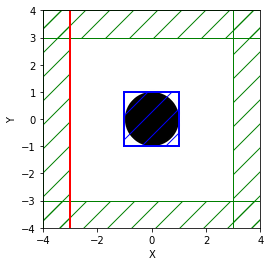

In [2]:
plt.figure()
sim.plot2D()

The spatial map of the absorbed power density shows that most of the absorption occurs in a small region near the back surface of the cylinder (i.e., on the opposite side of the incident planewave).

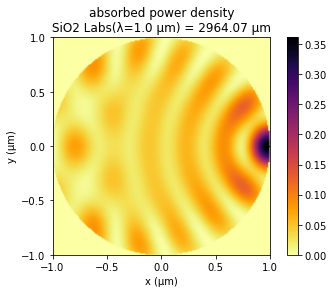

In [3]:
plt.figure()
x = np.linspace(-r, r, Dz.shape[0])
y = np.linspace(-r, r, Dz.shape[1])
plt.pcolormesh(
    x,
    y,
    np.transpose(absorbed_power_density),
    cmap="inferno_r",
    shading="gouraud",
    vmin=0,
    vmax=np.amax(absorbed_power_density),
)
plt.xlabel("x (μm)")
plt.xticks(np.linspace(-r, r, 5))
plt.ylabel("y (μm)")
plt.yticks(np.linspace(-r, r, 5))
plt.gca().set_aspect("equal")
plt.title(
    "absorbed power density"
    + "\n"
    + "SiO2 Labs(λ={} μm) = {:.2f} μm".format(
        wvl, wvl / np.imag(np.sqrt(SiO2.epsilon(fcen)[0][0]))
    )
)
plt.colorbar()